# Kredi Kartı Sahtekarlık (Fraud) Tespiti ve Maliyet Duyarlı (Cost-Sensitive) Risk Modellemesi
**Geliştiren:** Barış Eren Şahin | **Hedef:** Finans & Risk Analitiği

## Proje Amacı ve Motivasyon
Bankacılık sektöründe sahtekarlık (fraud) tespiti, standart makine öğrenmesi problemlerinden (örneğin müşteri churn tahmini) çok daha zorlu bir "Aşırı Sınıf Dengesizliği (Extreme Class Imbalance)" problemidir. Bu projede, Kaggle'ın standart "Kredi Kartı Fraud" veri seti kullanılarak sadece yüksek "Accuracy" (Doğruluk) elde etmek hedeflenmemiş; aksine **"False Positive" (müşteri mağduriyeti)** ile **"False Negative" (finansal kayıp)** arasındaki o hassas denge (Trade-off) optimize edilmiştir.

## Kullanılan Yöntemler
- Keşifçi Veri Analizi (EDA) ve Dengesizlik Tespiti
- XGBoost ile Scale Pos Weight (Cost-Sensitive Learning)
- Precision-Recall (AUPRC) Optimizasyonu
- İş Simülasyonu: Kar/Zarar (Cost Matrix) Hesaplaması

# Imports and Data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

df = pd.read_csv('creditcard.csv')

print(f"Veri boyutu: {df.shape[0]} satır, {df.shape[1]} kolon var.")

# eksik veri var mı bakalım
eksik_sayisi = df.isnull().sum().max()
print(f"En çok eksik olan kolondaki NaN sayısı: {eksik_sayisi}") 
# Eğer 0 çıkarsa tertemiz bir verimiz vardır.

Veri boyutu: 284807 satır, 31 kolon var.
En çok eksik olan kolondaki NaN sayısı: 0


# EDA


İşlem Dağılımı:
Class
0    284315
1       492
Name: count, dtype: int64
Toplam içindeki Fraud oranı: %0.173



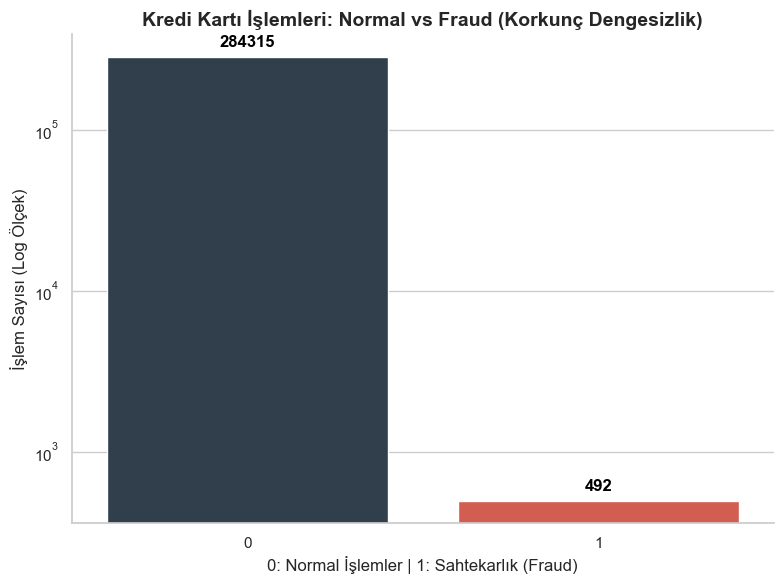

In [2]:
# Sınıflara bakalım
siniflar = df['Class'].value_counts()
print("\nİşlem Dağılımı:")
print(siniflar)

oran = (siniflar[1] / len(df)) * 100
print(f"Toplam içindeki Fraud oranı: %{oran:.3f}\n")

plt.figure(figsize=(8, 6))

# Renkleri ayarlamaları falan
ax = sns.countplot(x='Class', hue='Class', data=df, palette=['#2C3E50', '#E74C3C'], legend=False)
plt.title('Kredi Kartı İşlemleri: Normal vs Fraud (Korkunç Dengesizlik)', fontsize=14, fontweight='bold')
plt.yscale('log') 
plt.ylabel('İşlem Sayısı (Log Ölçek)', fontsize=12)
plt.xlabel('0: Normal İşlemler | 1: Sahtekarlık (Fraud)', fontsize=12)

# Çubukların tam tepesine rakamları yazdıran döngü
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black', 
                xytext=(0, 5), textcoords='offset points')

# Sol üst köşeye veya grafiğe sınırları çizen ufak bir çerçeve ekleyelim
sns.despine()
plt.tight_layout()
plt.show()

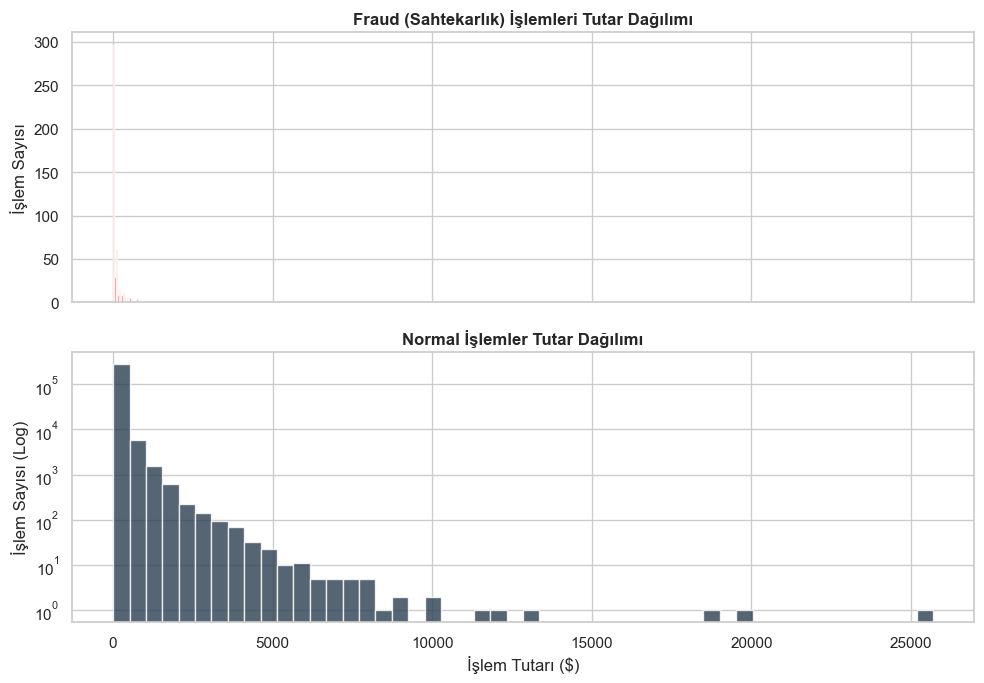

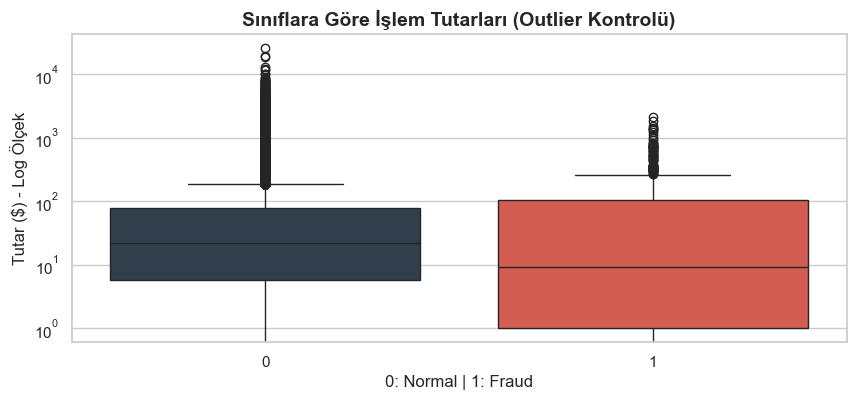


--- BUSINESS INSIGHT ---
1. Fraud işlemler genelde düşük tutarlarda (1$-100$ arası) kümelenmiş. Dikkat çekmemek için küçük çekiyorlar.
2. Normal işlemlerde ise 25.000$'a kadar çıkan devasa (outlier) tutarlar var.
3. Demek ki 'Tutar çok yüksekse kesin sahtekarlıktır' varsayımı YANLIŞTIR. Kural tabanlı sistemler bu yüzden çöker!


In [3]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,7))

# Fraud Histogramı
bins = 50
ax1.hist(df.Amount[df.Class == 1], bins=bins, color='#E74C3C', alpha=0.8)
ax1.set_title('Fraud (Sahtekarlık) İşlemleri Tutar Dağılımı', fontsize=12, fontweight='bold')
ax1.set_ylabel('İşlem Sayısı')

# Normal İşlem Histogramı (Log ölçekli ki yığılma anlaşılsın)
ax2.hist(df.Amount[df.Class == 0], bins=bins, color='#2C3E50', alpha=0.8)
ax2.set_title('Normal İşlemler Tutar Dağılımı', fontsize=12, fontweight='bold')
ax2.set_xlabel('İşlem Tutarı ($)', fontsize=12)
ax2.set_ylabel('İşlem Sayısı (Log)')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

# Tutar (Amount) için Kutu Grafiği (Outlier tespiti)
plt.figure(figsize=(10, 4))
sns.boxplot(x='Class', y='Amount', hue='Class', data=df, palette=['#2C3E50', '#E74C3C'], legend=False)
plt.title('Sınıflara Göre İşlem Tutarları (Outlier Kontrolü)', fontsize=14, fontweight='bold')
# Y eksenini yine logaritmik yapıyoruz çünkü normal işlemlerin 25 bin dolarlık outlier'ları var
plt.yscale('log') 
plt.xlabel('0: Normal | 1: Fraud', fontsize=12)
plt.ylabel('Tutar ($) - Log Ölçek', fontsize=12)
plt.show()

print("\n--- BUSINESS INSIGHT ---")
print("1. Fraud işlemler genelde düşük tutarlarda (1$-100$ arası) kümelenmiş. Dikkat çekmemek için küçük çekiyorlar.")
print("2. Normal işlemlerde ise 25.000$'a kadar çıkan devasa (outlier) tutarlar var.")
print("3. Demek ki 'Tutar çok yüksekse kesin sahtekarlıktır' varsayımı YANLIŞTIR. Kural tabanlı sistemler bu yüzden çöker!")

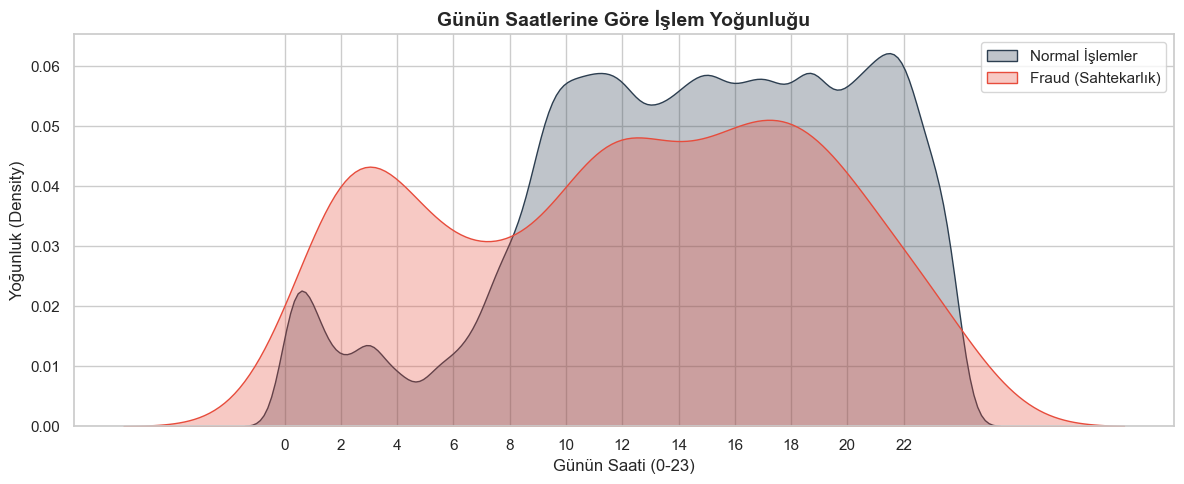

In [4]:
# 'Time' kolonu saniye cinsinden verilmiş (ilk işlemden itibaren geçen saniye). 
# Bunu 24 saatlik dilimlere çevirelim ki insan gözüyle anlayabilelim.
# 3600 saniye = 1 saat.
df['Hour'] = (df['Time'] / 3600) % 24

plt.figure(figsize=(12, 5))
# KDE (Kernel Density Estimation) plot ile yoğunluk çizdiriyoruz
sns.kdeplot(df[df['Class'] == 0]['Hour'], label='Normal İşlemler', color='#2C3E50', fill=True, alpha=0.3)
sns.kdeplot(df[df['Class'] == 1]['Hour'], label='Fraud (Sahtekarlık)', color='#E74C3C', fill=True, alpha=0.3)

plt.title('Günün Saatlerine Göre İşlem Yoğunluğu', fontsize=14, fontweight='bold')
plt.xlabel('Günün Saati (0-23)', fontsize=12)
plt.ylabel('Yoğunluk (Density)', fontsize=12)
plt.xticks(np.arange(0, 24, 2)) # X eksenini 2 saatte bir bölelim
plt.legend()
plt.tight_layout()
plt.show()

# --- Not ---
# Grafiğe dikkatli baktığımızda Normal işlemler sabah 04:00 - 08:00 arası (insanlar uyurken) dibe vuruyor.
# Ama Fraud işlemler (Kırmızı) o saatlerde o kadar da düşmüyor! Oransal olarak gece yapılan işlemlerin sahte olma ihtimali çok daha yüksek.

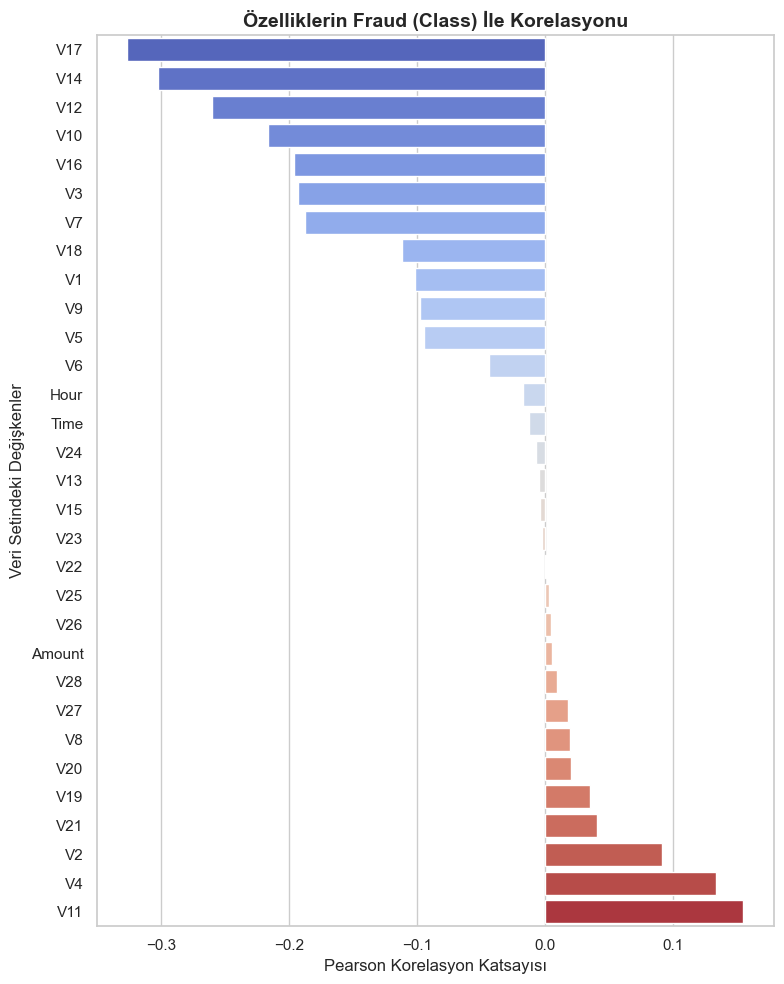

In [5]:
# V1, V2... V28 nedir bilmiyoruz. Ama hangilerinin dolandırıcılığı yakalamada 
# daha çok işimize yarayacağını bulabiliriz. Sadece 'Class' ile olan korelasyonlara bakalım.

plt.figure(figsize=(8, 10))
# Tüm matrisi çizip göz yormak yerine, sadece hedefe (Class) odaklanıyoruz
corr_with_class = df.corr()['Class'].drop('Class').sort_values()

# Eksi korelasyonlar mavi, artılar kırmızı tonlarda
sns.barplot(y=corr_with_class.index, x=corr_with_class.values, hue=corr_with_class.index, palette='coolwarm', legend=False)
plt.title('Özelliklerin Fraud (Class) İle Korelasyonu', fontsize=14, fontweight='bold')
plt.xlabel('Pearson Korelasyon Katsayısı', fontsize=12)
plt.ylabel('Veri Setindeki Değişkenler', fontsize=12)
plt.tight_layout()
plt.show()

# --- Önemli ---
# Grafiğin en altındaki V17, V14, V12 gibi kolonlara dikkat etttiğimizde bunların eksi yönlü korelasyonun çok yüksek olduğunu görüyoruz. 
# Yani XGBoost modelini kurduğumuzda, model büyük ihtimalle "V17 değeri çok düşükse bu kesin sahtekarlıktır" diyecek.

# Stratified Split and Cost Sensitive XGBoost

In [6]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

print("--- VERİ HAZIRLIĞI VE MODEL KURULUMU ---\n")

# 1. Gereksiz Kolonları Atalım
# Orijinal time kolonunu saniye cinsinden olduğu için atıyoruz, çünkü erine bizim ürettiğimiz daha anlamlı saat kolonunu kullanacağız.
X = df.drop(['Class', 'Time'], axis=1)
y = df['Class']

# 2. Stratified Train-Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #Dengesiz verilerde oranları korumak için şarttır.

print(f"Eğitim Seti Boyutu: {X_train.shape[0]} satır")
print(f"Test Seti Boyutu: {X_test.shape[0]} satır")
print(f"Eğitim setindeki Fraud Oranı: %{(y_train.sum() / len(y_train)) * 100:.3f}")
print(f"Test setindeki Fraud Oranı: %{(y_test.sum() / len(y_test)) * 100:.3f}\n")

# 3. Cost-Sensitive yani maliyete duyarlı öğrenme için ağıırlık hesaplama yapalım
# Formül: negatif sınıf sayısı / pozitif sınıf sayısı
neg_class_count = y_train.value_counts()[0]
pos_class_count = y_train.value_counts()[1]
scale_weight = neg_class_count / pos_class_count

print("--- MODEL AĞIRLIKLANDIRMA (COST-SENSITIVE) ---")
print(f"XGBoost 'scale_pos_weight' parametresi: {scale_weight:.2f}")
# "Önemli not: Bu değer modele şunu söyler: 1 tane Fraud işlemi kaçırmanın cezası, 577 tane normal işlemi yanlış bilmekle eşdeğerdir.

# 4. XGBoost Modelini Tanımlama
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_weight,  # Sihirli parametremiz
    random_state=42,
    eval_metric='aucpr', # ROC-AUC dengesiz veride yanıltır, o yüzden PR-AUC (Precision-Recall) kullanıyoruz.
    max_depth=5,
    learning_rate=0.05,
    n_estimators=200
)

# modeli eğitelim
print("\nXGBoost Modeli eğitiliyor, lütfen bekleyin...")
xgb_model.fit(X_train, y_train)
print("Model başarıyla eğitildi!")

--- VERİ HAZIRLIĞI VE MODEL KURULUMU ---

Eğitim Seti Boyutu: 227845 satır
Test Seti Boyutu: 56962 satır
Eğitim setindeki Fraud Oranı: %0.173
Test setindeki Fraud Oranı: %0.172

--- MODEL AĞIRLIKLANDIRMA (COST-SENSITIVE) ---
XGBoost 'scale_pos_weight' parametresi: 577.29

XGBoost Modeli eğitiliyor, lütfen bekleyin...
Model başarıyla eğitildi!


--- MODEL PERFORMANSI VE RİSK ANALİZİ ---

PR-AUC Skorumuz: 0.853 (Bu kadar dengesiz bir veri için bayağı iyi bir oran)


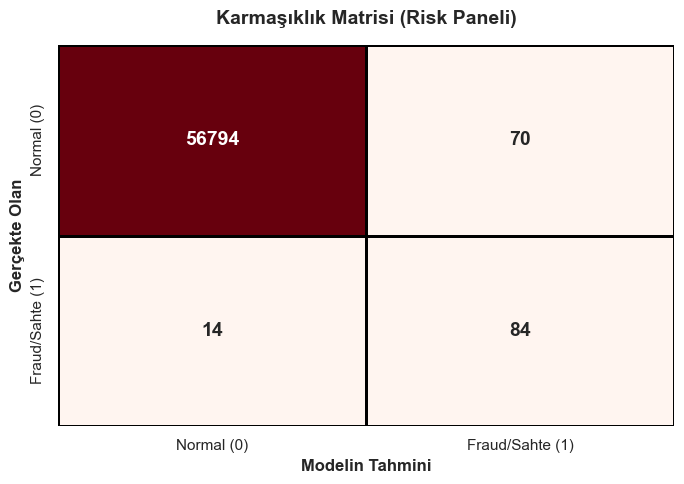

In [7]:
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("--- MODEL PERFORMANSI VE RİSK ANALİZİ ---\n")

# Modelin test setindeki olasılık tahminlerini alıyoruz
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
y_pred = xgb_model.predict(X_test)

# PR-AUC Skoru 
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

print(f"PR-AUC Skorumuz: {pr_auc:.3f} (Bu kadar dengesiz bir veri için bayağı iyi bir oran)")

# Karmaşıklık Matrisi (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))

# Risk hissini vermek için kırmızı tonları kullandım.
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False, 
                 annot_kws={"size": 14, "weight": "bold"}, 
                 linewidths=1, linecolor='black')

plt.title('Karmaşıklık Matrisi (Risk Paneli)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Modelin Tahmini', fontsize=12, fontweight='bold')
plt.ylabel('Gerçekte Olan', fontsize=12, fontweight='bold')

# Eksen etiketlerini okunabilir hale getirelim
ax.set_xticklabels(['Normal (0)', 'Fraud/Sahte (1)'], fontsize=11)
ax.set_yticklabels(['Normal (0)', 'Fraud/Sahte (1)'], fontsize=11)

plt.tight_layout()
plt.show()

# Önemli not: Sağ Üst (Masumların bloke olan kartları) ve Sol Alt (dolandırıcılar).

In [8]:
# Model bankaya ne kadar para kurtardı?
# Gerçek hayatta her yanlış alarmın (False Positive) bankaya bir maliyeti var.
# Müşteri hizmetleri arar, müşteri sinirlenir vs. Buna işlem başı 10 dolar diyelim.
# Dolandırıcıyı kaçırmanın (False Negative) cezası ise ortalama sepet tutarıdır. 
# Yukarıda analiz etmiştik, fraud işlemlerin ortalaması kabaca 122 dolardı.

fp_maliyeti = 10 
fn_maliyeti = 122 

# Matristen değerleri koparalım
tn, fp, fn, tp = cm.ravel()

# Eğer hiç model olmasaydı bankanın maaliyeti: Tüm dolandırıcılar (tp + fn) x 122 dolar
toplam_dolandiricilik_maliyeti = (tp + fn) * fn_maliyeti

# Modelin bankaya ödettiği bedel (Kaçan dolandırıcılar + Boş yere rahatsız edilen masumlar)
modelin_maliyeti = (fn * fn_maliyeti) + (fp * fp_maliyeti)

# Bankanın cebinde kalan net para
kurtarilan_para = toplam_dolandiricilik_maliyeti - modelin_maliyeti

print("--- Sonuç ---")
print(f"Model olmasaydı dolandırcılık maliyeti: ${toplam_dolandiricilik_maliyeti}")
print(f"Modelin yanlış alarmlar yüzünden yarattığı maliyet: ${modelin_maliyeti}")
print(f"Kurtarılan net para: ${kurtarilan_para}")

# Not: Burada yapmamız gereken çıkarım şu: 
# modelimizin accuracy'sinin yüksek olmasından ziyade
# Modelimiz risk maliyetlerini minimize ederek 9548 dolar para kurtardı.

--- Sonuç ---
Model olmasaydı dolandırcılık maliyeti: $11956
Modelin yanlış alarmlar yüzünden yarattığı maliyet: $2408
Kurtarılan net para: $9548


### Kapanış ve Proje Notları

Sadece istatistiksel metrik kasmadık bu projede. Evet, %0.17 gibi inanılmaz dengesiz bir veride **0.853 PR-AUC** skoru tutturmak güzel bir teknik başarı. Ama asıl olay işin finansal tarafında bitiyor aslında.

Sırf test verisi üzerinde yaptığım o basit kâr/zarar simülasyonuna bakarsak; modeli devreye aldığımızda bankanın cebinde net **9.548 dolar** para kalıyor. Bunu tüm yıla ve devasa müşteri tabanına vurduğumuzda milyon dolarlık bir risk optimizasyonu demek bu. Modeli biraz "paranoyak" yaptık bilerek (scale_pos_weight ile), varsın masum müşteriye yanlış alarm gitsin ama dolandırıcı kaçmasın istedik.

**Peki eksiklerimiz neler? (Limitasyonlar)**
Gerçek hayat verisi böyle statik durmuyor maalesef. Aylar geçtikçe dolandırıcılar taktik değiştiriyor, biz buna "Data Drift" diyoruz. Yani modeli bir kere kurup bırakamayız, sürekli yeni verilerle besleyip baştan eğitmemiz (retrain) gerekecek gerçek bir senaryoda.

Bir de artık kütüphane çağırmayı (import xgboost vb.) bırakıp işin biraz daha matematiğine inmek istiyorum bundan sonraki aşamada. Hiçbir hazır makine öğrenmesi paketi kullanmadan, sadece NumPy ile matematiğini kendim kurarak sıfırdan bir algoritma yazmayı deneyeceğim.